##Authors:

###Lloyd Linton Jones
###Ihona Maria Correa de Cabo

# GradCam: Visual Explanations via Gradient-based Localization

At the end of this lab, you will get familiarized with

*    PCA, T-SNE and Umap visualization of layer results
*   Applying GradCam for a CNN classification
*   Visualizing gradcam results

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Add sufficient comments and explanations wherever necessary.
*   **Once you have the code completed, use GPU to train model faster.**
* This lab must be worked in pairs. Make sure that when you submit your lab you change the name to: **07_lab_Student1FullName_Student2FullName.ipynb**
---

In [ ]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.7 MB/s eta 0:00:00


In [ ]:
# Libraries
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image
import keras
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change path accordingly.
labs_path = '/content/drive/MyDrive/2425_MBDS_DL_Practicals/lab07_visualization/'

In [ ]:
# if using a local zip file
path_to_zip_file = '/content/drive/MyDrive/data_folder.zip'
directory_to_extract_to = '/content/data_folder/'

import zipfile
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

# Exercise 1: Features extraction (1.5 points)

*In this section, we explored different techniques available to visualize via dimensionality reduction features developed through CNN models, first we train a model and extract its features. We use colorectal_histology from tfds leveraged before. Remember that this is multiclass problem with 8 possible categories.*


1**.1 First, lets build a model and assess its performance:**
*   Load "colorectal_histology" from TFDS
*   Split the data into train, test and validation. use 20% for test, 10% for validation and the remaining 70% for training.
*   Convert the labels to one-hot encoded form.
*   Normalize the images.

In [ ]:
from keras.backend import clear_session
clear_session()

In [ ]:
# Load the dataset
dataset, info = tfds.load("colorectal_histology", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/incomplete.9KCBPH_2.0.0/colorectal_histology-train.tf…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [ ]:
label_names = info.features["label"].names
print("Label names:", label_names)

Label names: ['tumor', 'stroma', 'complex', 'lympho', 'debris', 'mucosa', 'adipose', 'empty']


In [ ]:
# Split dataset into train (70%), validation (10%), and test (20%)
train_dataset = dataset['train'].take(int(info.splits['train'].num_examples * 0.7))
val_dataset = dataset['train'].skip(int(info.splits['train'].num_examples * 0.7)).take(int(info.splits['train'].num_examples * 0.1))
test_dataset = dataset['train'].skip(int(info.splits['train'].num_examples * 0.8))

In [ ]:
len(train_dataset)

3500

In [ ]:
len(val_dataset)

500

In [ ]:
len(test_dataset)

1000

In [ ]:
# Define preprocessing function
def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32) # Normalize image
    label = tf.cast(label, tf.int32) # Cast label to tf.int32
    label = tf.one_hot(label, depth=8) # One-hot encode the label

    return image, label

In [ ]:
# Apply preprocessing
train_dataset = train_dataset.map(preprocess).batch(32).shuffle(1000)
val_dataset = val_dataset.map(preprocess).batch(32)
test_dataset = test_dataset.map(preprocess).batch(32)

In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>

**1.2 Load a fine tuned InceptionNet model pretrained on ImageNet**


*   Load the model `07_lab_gradcam_model_exercise1_inceptionnet.keras` provided to you. This was trained for 50 epochs on this dataset, starting from the Imagenet pretrained MobileNet.



In [ ]:
keras.__version__

'3.5.0'

In [ ]:
Ihona_file_path = '/content/drive/My Drive/MASTER/Segundo año/Deep Learning/Lab_unit_7 - GradCam/data_folder_new/01_colorectal_histology_models/07_lab_gradcam_model_exercise1_inceptionnet.keras' # use de new version from 18th november
Lloyd_file_path= "/content/data_folder/data_folder/01_colorectal_histology_models/07_lab_gradcam_model_exercise1_inceptionnet.keras"

In [ ]:
from tensorflow.keras.models import load_model

model = load_model(Lloyd_file_path)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 3, 3, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,591,018 (93.81 MB)

 Trainable params: 24,556,584 (93.68 MB)

 Non-trainable params: 34,432 (134.50 KB)

 Optimizer params: 2 (12.00 B)

**1.3 Build a model to extract the features**

*   Obtain the name of the layers. Look for *global_max_pooling2d* layer, as this will be the one where we extract the features from.
*   Create a model that outputs the features from the chosen layer. Extract the intermediate features by using the predict function from the model with the test set. **Hint:** tensorflow.keras.models has a Model function that you can use to create the intermediate model. Explore its parameters






In [ ]:
# Find the name of the layers
for layer in model.layers:
  # show paramenters of the layer
  print(layer.get_config())

{'batch_shape': (None, 150, 150, 3), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_7'}
{'name': 'inception_v3', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 150, 150, 3), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_6'}, 'registered_name': None, 'name': 'input_layer_6', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_282', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 32, 'kernel_size': (3, 3), 'strides': (2, 2), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_nam

**NOTE:** global_max_pooling2d layer does not exist in the provided model, so we will use global_average_pooling2d_2 instead.

In [ ]:
from tensorflow.keras.models import Model

# Layer from which to extract the features
layer_name = 'global_average_pooling2d_2'

# Model that outputs the features from the chosen layer
intermediate_model = Model(inputs=model.inputs,
                           outputs=model.get_layer(layer_name).output)

# Extract the intermediate features
features = intermediate_model.predict(test_dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 285ms/step


In [ ]:
print(features)

[[   0.         22.382923  157.40596  ...    0.          0.
   950.95184 ]
 [   0.          0.        118.93511  ...    0.          0.
   673.70056 ]
 [   0.         13.822629   51.712772 ...    0.          0.
  1045.9806  ]
 ...
 [   0.          0.        160.37039  ...    0.          0.
   676.2888  ]
 [   0.         16.46555   112.01388  ...    0.          0.
   852.0784  ]
 [   0.          0.        115.84368  ...    0.          0.
   965.88574 ]]


## Exercise 2: Feature visualization with PCA (1 point)

*Principal component analysis is a popular technique for analyzing large datasets containing a high number of dimensions by reducing dimensionality while preserving the maximum amount of information, and enabling the visualization of multidimensional data.*

*For the features extracted, apply PCA and visualize the results. Comment on what you see and the advantages of this visualization in terms of explainability.*

**2.1 Perform and visualize PCA:**

*   Flatten the feature maps in order to use them in the PCA. You can do this with the reshape function.
*   Perform PCA from sklearn.decomposition with 2 components. You can use sklearn function for this.
*   Plot the resulting 2 components, color the observations by class.



In [ ]:
# Step 1: Flatten the feature maps
flattened_features = features.reshape(features.shape[0], -1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 2: Normalize the features before applying PCA
scaler = StandardScaler()
scaled_features = scaler.fit_transform(flattened_features)

# Step 3: Perform PCA with 2 components
pca = PCA(n_components=2) # We reduce the features to 2 dimensions
pca_result = pca.fit_transform(scaled_features)

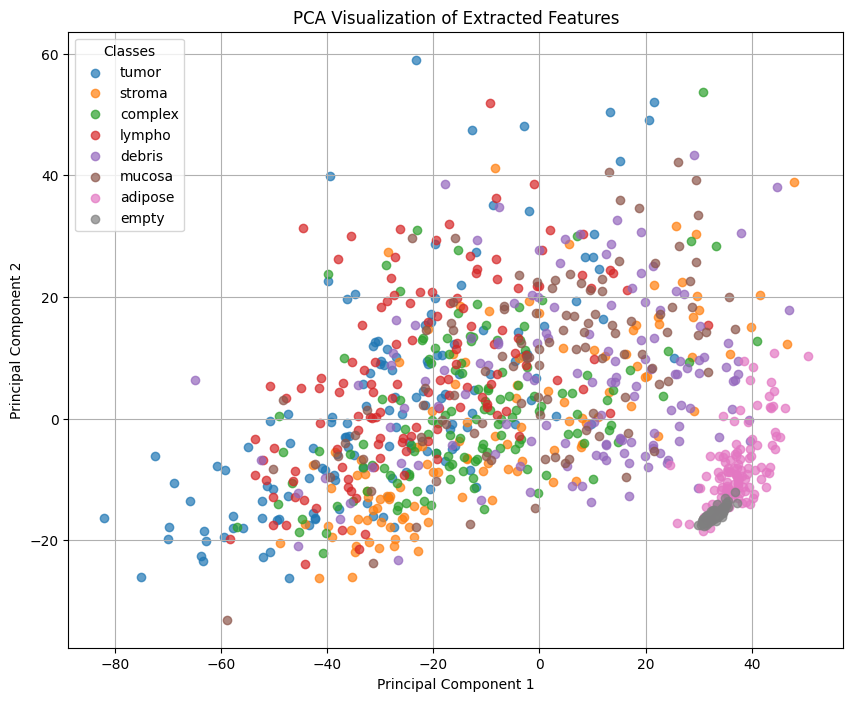

In [ ]:
# Step 4: Plot the results, and color the observations by class

# Extract the features and labels from the test_dataset
all_features = []
all_labels = []

for batch in test_dataset: # Loop through the dataset (batches of data)
    features_batch, labels_batch = batch  # Separate features and labels in each batch
    all_features.append(features_batch.numpy())  # Convert features to numpy
    all_labels.append(labels_batch.numpy())     # Convert labels to numpy

# Concatenate all batches into a single dataset
all_features = np.concatenate(all_features, axis=0)  #  Contains all the features extracted from the test dataset
all_labels = np.concatenate(all_labels, axis=0)   # Contains all the corresponding labels

# Step 2: Convert one-hot encoded labels into class indices
class_indices = np.argmax(all_labels, axis=1) # This results in a list of integers representing the class of each sample.

# Visualize the PCA result
plt.figure(figsize=(10, 8))
unique_classes = np.unique(class_indices)

for class_label in unique_classes:
    class_indices_filter = np.where(class_indices == class_label)
    plt.scatter(
        pca_result[class_indices_filter, 0], # PCA's first component for this class
        pca_result[class_indices_filter, 1], # PCA's second component for this class
        label=label_names[class_label],  # Add the label name
        #label=f'Class {class_label}', # Add the encoded label for the legend
        alpha=0.7
    )

plt.title("PCA Visualization of Extracted Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Classes")
plt.grid(True)
plt.show()

## Exercise 3: Feature visualization with T-SNE (1 point)

*In order to visualize the features of a higher dimension data, t-SNE can be used. t-SNE converts the affinities of the data points to probabilities. It recreates the probability distribution in a low-dimensional space. It is very helpful in visualizing features of different layers in a neural network.*

*You can find more information about t-SNE [here](https://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne)*

**3.1 Use TSNE to visualize the features extracted from the neural network before. Obtain 2 components so you can easily visualize it in a 2-D plot, show your results**
**Hint:** TSNE function is available in the *sklearn.manifold* package.


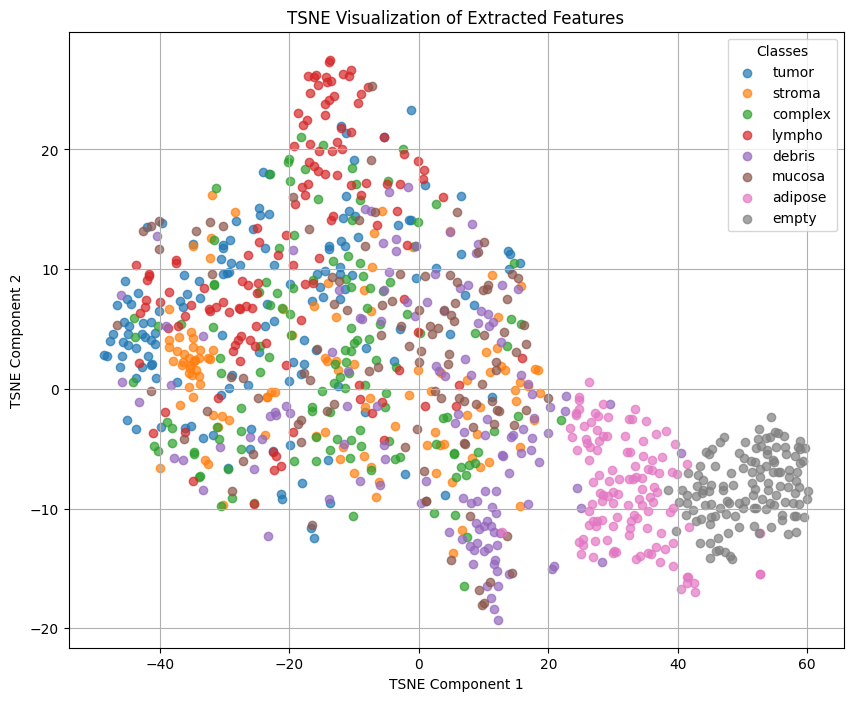

In [ ]:
from sklearn.manifold import TSNE

# Apply TSNE to the flattened features
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(scaled_features)

# Plot the TSNE results
# Extract the features and labels from the test_dataset
all_features = []
all_labels = []

for batch in test_dataset: # Loop through the dataset (batches of data)
    features_batch, labels_batch = batch  # Separate features and labels in each batch
    all_features.append(features_batch.numpy())  # Convert features to numpy
    all_labels.append(labels_batch.numpy())     # Convert labels to numpy

# Concatenate all batches into a single dataset
all_features = np.concatenate(all_features, axis=0)  #  Contains all the features extracted from the test dataset
all_labels = np.concatenate(all_labels, axis=0)   # Contains all the corresponding labels

# Step 2: Convert one-hot encoded labels into class indices
class_indices = np.argmax(all_labels, axis=1) # This results in a list of integers representing the class of each sample.

# Visualize the TSNE result
plt.figure(figsize=(10, 8))
unique_classes = np.unique(class_indices)

for class_label in unique_classes:
    class_indices_filter = np.where(class_indices == class_label)
    plt.scatter(
        tsne_result[class_indices_filter, 0], # TSNE's first component for this class
        tsne_result[class_indices_filter, 1], # TSNE's second component for this class
        label=label_names[class_label],  # Add the label name
        alpha=0.7
    )

plt.title("TSNE Visualization of Extracted Features")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.legend(title="Classes")
plt.grid(True)
plt.show()

# Exercise 4: Visualize features with UMAP (1 point)

*In this section, we will visualize different layers results via the dimensionality reduction technique UMAP (Uniform Manifold Approximation and Projection). This technique is a non-linear dimensionality reduction algorithm that preserves both local and global structures in the data. You can read more on its [paper](https://arxiv.org/abs/1802.03426)*



**4.1 Use UMAP to visualize results of last layer for the test set. Follow this steps:**
*   Apply the dimensionality reduction with umap from umap.umap_.
*   Set the model to use 5 neighbors and a minimum distance of 0.1 with euclidean as distance metric.
*   Once fitted and transform, visualize the UMAP embeddings as a scatterplot, with the classes as color. Use cmap = "tab10" inside the plt.scatter.



In [ ]:
!pip install --upgrade matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 84.2 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.0
    Uninstalling matplotlib-3.8.0:
      Successfully uninstalled matplotlib-3.8.0


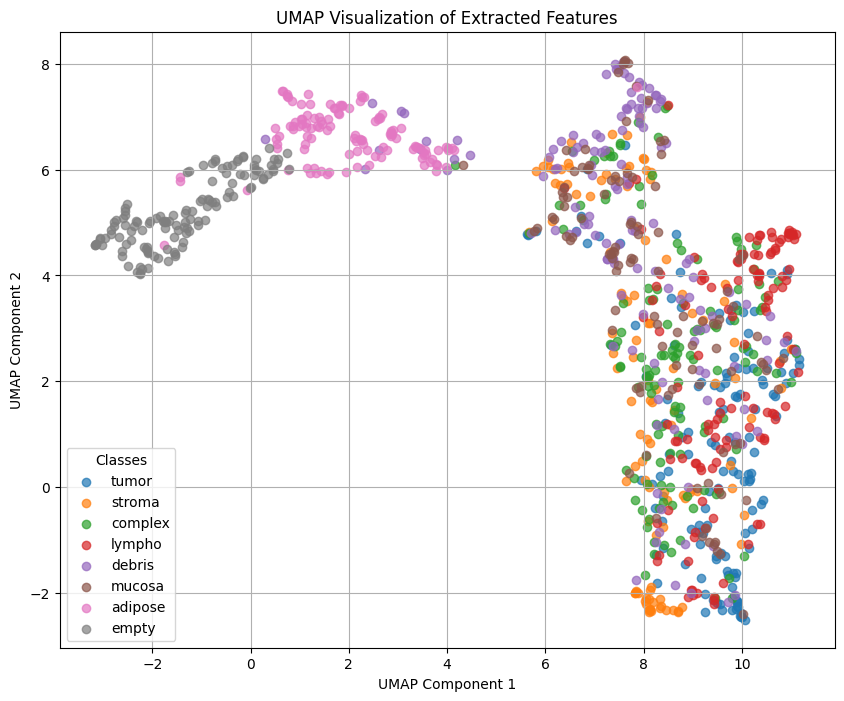

In [ ]:
from umap import UMAP
from matplotlib import colormaps

# Apply UMAP
umap = UMAP(n_components=2, n_neighbors=5, min_dist=0.1, metric='euclidean')
umap_result = umap.fit_transform(scaled_features)

# Plot the UMAP results
# Extract the features and labels from the test_dataset
all_features = []
all_labels = []

for batch in test_dataset: # Loop through the dataset (batches of data)
    features_batch, labels_batch = batch  # Separate features and labels in each batch
    all_features.append(features_batch)  # Convert features to numpy
    all_labels.append(labels_batch.numpy())     # Convert labels to numpy

# Concatenate all batches into a single dataset
all_features = np.concatenate(all_features, axis=0)  #  Contains all the features extracted from the test dataset
all_labels = np.concatenate(all_labels, axis=0)   # Contains all the corresponding labels

# Convert one-hot encoded labels into class indices
class_indices = np.argmax(all_labels, axis=1) # This results in a list of integers representing the class of each sample.

# Visualize the UMAP result
plt.figure(figsize=(10, 8))
unique_classes = np.unique(class_indices)

# Generate the colormap from 'tab10'
cmap = colormaps.get_cmap('tab10')

for class_label in unique_classes:
    class_indices_filter = np.where(class_indices == class_label)
    plt.scatter(
        umap_result[class_indices_filter, 0], # UMAP's first component for this class
        umap_result[class_indices_filter, 1], # UMAP's second component for this class
        label=label_names[class_label],  # Add the label name
        c=[cmap(class_label)],  # Use color corresponding to the class label
        alpha=0.7
    )

plt.title("UMAP Visualization of Extracted Features")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(title="Classes")
plt.grid(True)
plt.show()

# Exercise 5: Applying GradCam with a pre-trained model (1.5 points)

 Gradient-weighted Class Activation Mapping (Grad-CAM) is a technique to visualize CNN's class decisions. It shows a visual explanation to make a more transparent models. It allows to see where the layer is focusing on to pick a class. You can learn more about GradCam from a code perspective on [keras tutorial](https://keras.io/examples/vision/grad_cam/) and theoretical aspects from the [paper](https://arxiv.org/abs/1610.02391)

**5.1 Using a VGG16 already trained, you will apply gradcam to 5 ImageNet images provided in the folder "data_imagenet_sample".**

*   Load the VGG16. model pretrained in ImageNet. Make sure to set include_top = True in this case as we are going to use ImageNet images.
*   Look for the name of the last convolution layer. Save the name in order to plot its gradcam visualization



In [ ]:
from keras.backend import clear_session
clear_session()

In [ ]:
images_path = '/content/data_folder/data_folder/05_imagenet_samples/'


In [ ]:
images_name = ["ILSVRC2012_val_00009111.JPEG",
               "ILSVRC2012_val_00043392.JPEG",
               "ILSVRC2012_val_00008973.JPEG",
               "ILSVRC2012_val_00047139.JPEG",
               "ILSVRC2012_val_00047998.JPEG"]

In [ ]:
# Load the VGG16 model
model = VGG16(weights="imagenet", include_top=True)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [ ]:
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Find and save the last convolutional layer's name
conv_layer_name = "block5_conv3"

**5.2 Explore the 5 imagenet images:**

*   Load the images provided in `data_imagenet_sample`
*   Preprocessed them, according to what the model requires. Hint: look for the preprocess function in keras.applications.vgg16 (starter code provided)
*   Predict the class for each image. Obtain the probability and label. For this, keras.applications.imagenet_utils provides a decode predictions function
*   Plot the image and print both the probability and label


You can use this base code to load the images:
```python
from keras.applications.vgg16 import VGG16, preprocess_input
# Load and preprocess the ImageNet images
def load_images(folder_path, images_name):
  image_size = (224, 224)
  images = []
  # Load images
  for image_name in images_name:
    # Load
    img = image.load_img(folder_path + image_name, target_size=image_size)
    # Preprocess image
    preprocessed_img = preprocess_input(image.img_to_array(img))
    # Add to images
    images.append(preprocessed_img)
  return images

```


We adapt the starter code provided to load the images, resize them to (224, 224), preprocess them and finally store both the processed image and the original images (for plotting afterwards).

In [ ]:
def load_images(images_path, images_name):
  image_size = (224, 224)
  images = []
  original_images = []
  # Load images
  for image_name in images_name:
    # Load
    img = image.load_img(images_path + image_name, target_size=image_size)
    original_images.append(img)  # Save original for plotting
    # Preprocess image
    preprocessed_img = preprocess_input(image.img_to_array(img))
    # Add to images
    images.append(preprocessed_img)
  return np.array(images), original_images

In [ ]:
# Load the images
images_preprocessed, original_images = load_images(images_path, images_name)

In [ ]:
predictions = model.predict(images_preprocessed)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


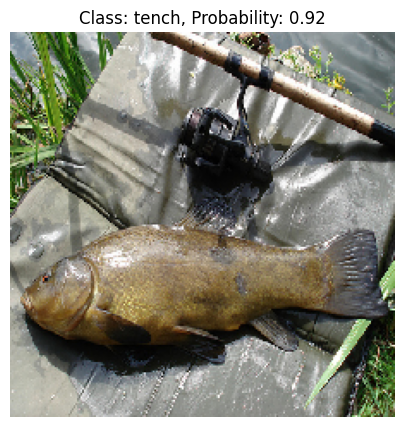

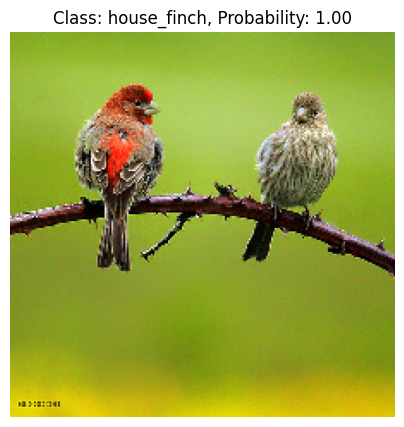

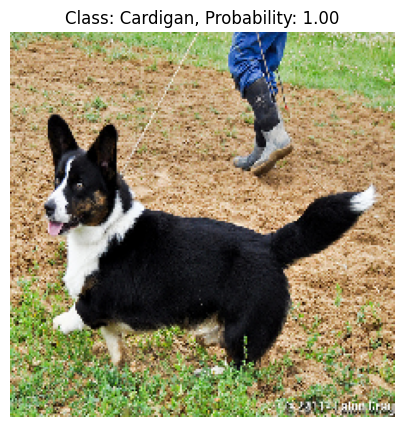

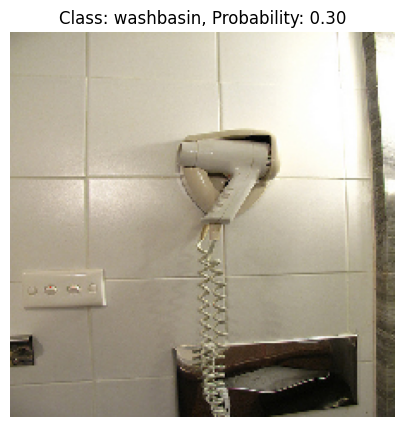

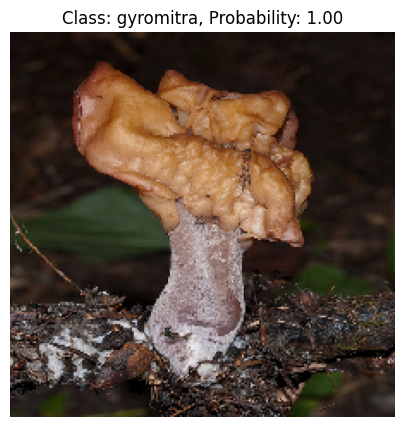

In [ ]:
for i, img in enumerate(original_images):
  # Decode predictions
  decoded_prediction = decode_predictions(predictions, top=1)[i][0]  # Get the top-1 prediction
  class_label = decoded_prediction[1]  # Class label
  probability = decoded_prediction[2]  # Probability

  # Plot the image
  plt.figure(figsize=(5, 5))
  plt.imshow(img)
  plt.axis('off')
  plt.title(f"Class: {class_label}, Probability: {probability:.2f}")
  plt.show()

**5.3 Create the gradcam heatmap:**
*   The first step is to create a new model that maps the input image to the activations of the last convolutional layer and the output predictions.
*   Use a GradientTape to compute the gradient of the top predicted class (or a chosen class) with respect to the activations of the last convolutional layer. Use the model created as first step for this.
*   Calculate the relevance scores by taking the gradient of the output neuron (top predicted or chosen) with respect to the output feature map of the last convolutional layer.
*   Calculate a vector where each entry is the mean intensity of the gradient over a specific feature map channel. Hint: use tf.reduce_mean
*   Multiply each channel in the feature map array by its corresponding pooled gradient value to obtain the heatmap class activation.
*   For visualization purposes, normalize the heatmap values between 0 and 1. Hint: Use the functions tf.maximum and tf.math.reduce_max
* Make sure the final heatmap is a NumPy array that you can display with plt.matshow


In [ ]:
# Extract the last convolutional layer that was stored before (block5_conv3)
last_conv_layer = model.get_layer(conv_layer_name)

In [ ]:
# Create a model that outputs both the last conv layer's activations and predictions
gradcam_model = tf.keras.models.Model(
    inputs=model.inputs,
    outputs=[last_conv_layer.output, model.output]
)

In [ ]:
import tensorflow as tf

def make_gradcam_heatmap(images_preprocessed, gradcam_model):

    heatmaps = []
    titles = []

    for idx, processed_image in enumerate(images_preprocessed):
      # Expand dimensions for a single image (batch_size=1)
      single_image = tf.expand_dims(processed_image, axis=0)  # Shape becomes (1, 224, 224, 3)

      # GradientTape to compute Grad-CAM
      with tf.GradientTape() as tape:
        # Get conv layer output and predictions
        conv_output, predictions = gradcam_model(single_image)
        target_class = tf.argmax(predictions[0])  # Choose the top-predicted class
        target_score = predictions[:, target_class]  # Focus on the target class score

      # Compute gradients
      grads = tape.gradient(target_score, conv_output)

      # Calculate relevance scores (pooled gradients)
      pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

      # Weight the feature maps by the relevance scores
      weighted_feature_maps = conv_output[0] * pooled_grads
      heatmap = tf.reduce_sum(weighted_feature_maps, axis=-1)

      # Normalize the heatmap
      heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
      heatmaps.append(heatmap.numpy())  # Convert to NumPy for visualization

      # Save the title for each image
      titles.append(f"Image {idx+1} - Top Class: {target_class.numpy()}")

    return heatmaps, titles


**5.4 Display the heatmap for the 5 images**




In [ ]:
heatmaps, titles = make_gradcam_heatmap(images_preprocessed, gradcam_model)

In [ ]:
for idx, (heatmap, title) in enumerate(zip(heatmaps, titles)):
  print(title)

Image 1 - Top Class: 0
Image 2 - Top Class: 12
Image 3 - Top Class: 264
Image 4 - Top Class: 896
Image 5 - Top Class: 993


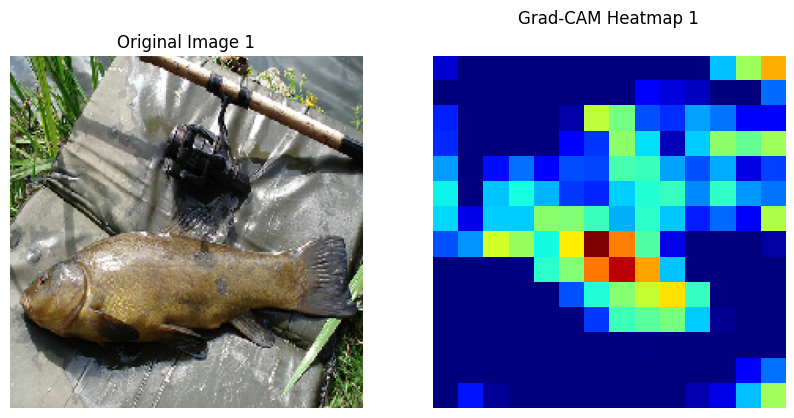

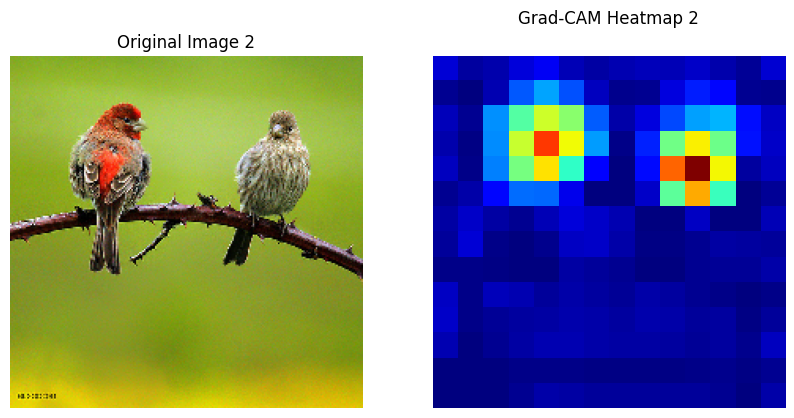

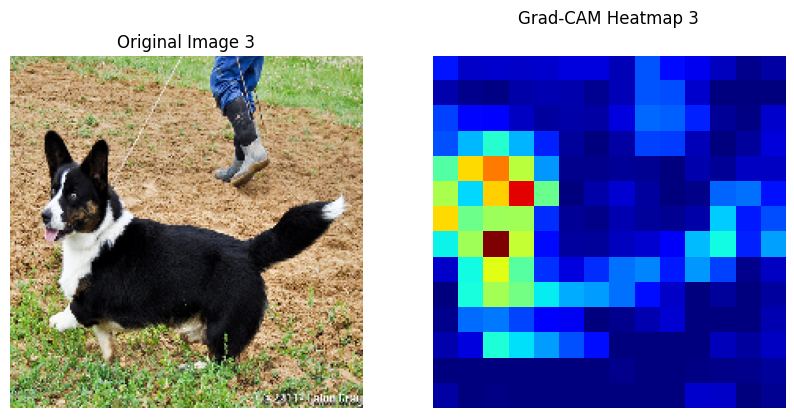

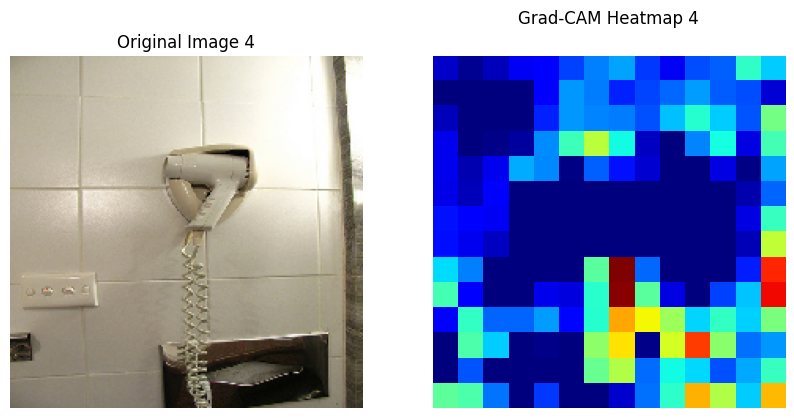

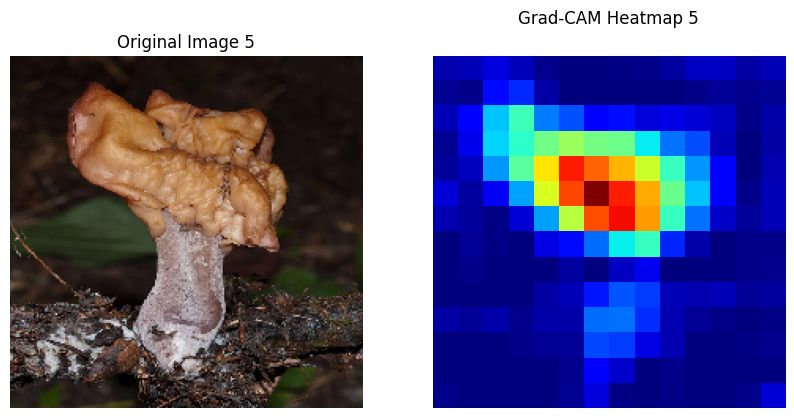

In [ ]:
# Plot the images and heatmaps
for idx, heatmap in enumerate(heatmaps):

  plt.figure(figsize=(10, 5))

  # Plot the original image
  plt.subplot(1, 2, 1)
  plt.imshow(original_images[idx])  # Original unprocessed image
  plt.axis('off')
  plt.title(f"Original Image {idx+1}")

  # Plot the heatmap
  plt.subplot(1, 2, 2)
  plt.matshow(heatmap, cmap='jet', fignum=False)
  plt.axis('off')
  plt.title(f"Grad-CAM Heatmap {idx+1}")

  # Show the current plot
  plt.show()


**5.5 Display a superimposed visualization of the 5 images:**

*   Rescale the heatmap values to the range of 0-255 and use the "jet" colormap to colorize the heatmap. Use the cm.get_cmap function
*   Convert the colorized heatmap to a PIL (Python Imaging Library) image, resize it to the dimensions of the original input image, and convert it back to a NumPy array.
*   Blend the colorized heatmap with the original image using the specified alpha value. Alpha should be a value that can be determined to set the transparency of the heatmap. This looks something like this: jet_heatmap * alpha + img. Then apply keras.utils.array_to_img to the result. This will create the superimposed image to be plotted with plt.imshow



In [ ]:
def display_gradcam(img, heatmap, alpha=0.4):
  # Rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmap)
  # Use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")
  # Use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]
  # Create an image with RGB colorized heatmap
  jet_heatmap = keras.utils.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.utils.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * alpha + img
  superimposed_img = keras.utils.array_to_img(superimposed_img)
  return superimposed_img

<ipython-input-53-fc655ab53bf0>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


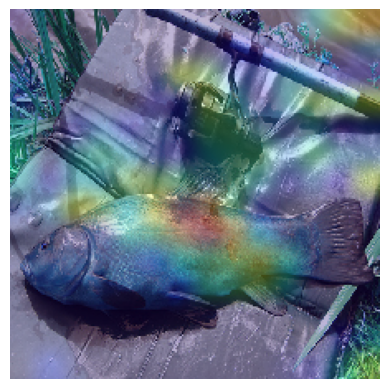

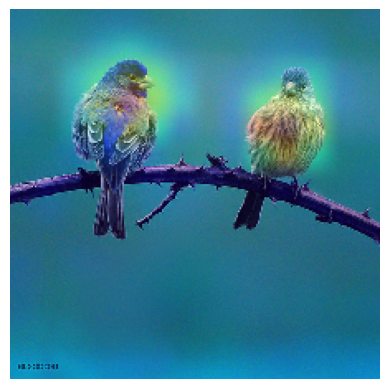

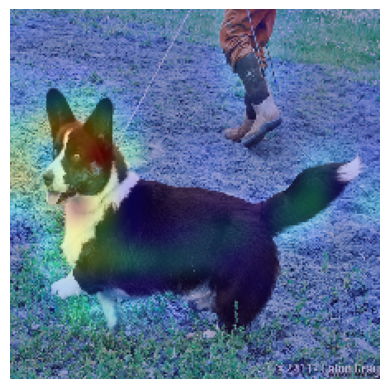

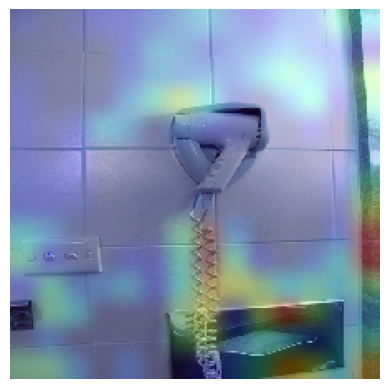

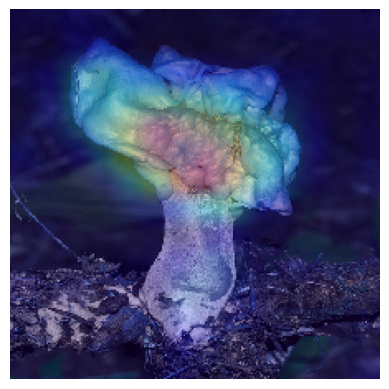

In [ ]:
heatmaps, titles = make_gradcam_heatmap(images_preprocessed, gradcam_model)

for i, img in enumerate(images_preprocessed):
  img = np.expand_dims(img, axis=0)
  # Generate class activation heatmap
  img = np.squeeze(img, axis=0)
  sup_img = display_gradcam(img, heatmaps[i])
  plt.imshow(sup_img)
  plt.axis('off')  # Remove axis ticks and labels
  plt.show()


# Exercise 6: Apply GradCam to with Chest X-ray images dataset (3 points)

*You have used this dataset in the last lab, it contains 5,863 Chest X-Ray images classified into 2 categories (Pneumonia/Normal). The normal chest X-ray shows clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia typically exhibits a focal lobar consolidation, whereas viral pneumonia manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.*



A code to load the data and print a couple of images is provided.

In [ ]:
# if using a local zip file
path_to_zip_file = '/content/data_folder/data_folder/06_chest_xray.zip'
directory_to_extract_to = '/content/data_folder/data_folder/06_chest_xray/'

import zipfile
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [ ]:
from keras.backend import clear_session
clear_session()
from tensorflow.keras.preprocessing.image import ImageDataGenerator

input_shape = (128, 128, 3)
img_size = 128
n_classes = 2

labs_path = '/content/data_folder/data_folder/06_chest_xray/'

# Define the paths to your train, test, and validation directories
train_dir = labs_path + '/chest_xray/train'
test_dir = labs_path + '/chest_xray/test'
val_dir = labs_path + '/chest_xray/val'

# Define the parameters for data augmentation and normalization
batch_size = 64
image_size = (128, 128)  # Adjust according to your image dimensions

# Create an instance of the ImageDataGenerator and set the preprocessing options
datagen = ImageDataGenerator(rescale=1.0/255)  # Normalize pixel values between 0 and 1

# Load and preprocess the training data
train_ds = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Load and preprocess the test data
test_ds = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Load and preprocess the validation data
valid_ds = datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Get the class indices from the flow_from_directory output
class_indices = train_ds.class_indices

# Reverse the class indices dictionary to get the class labels
class_names = {v: k for k, v in class_indices.items()}


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


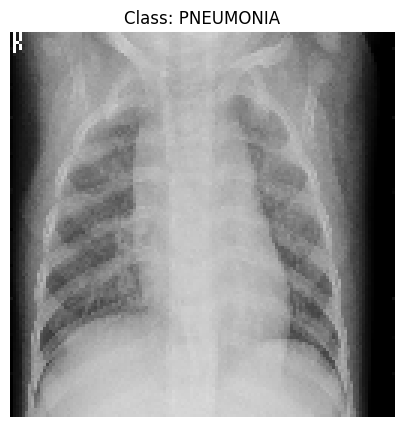

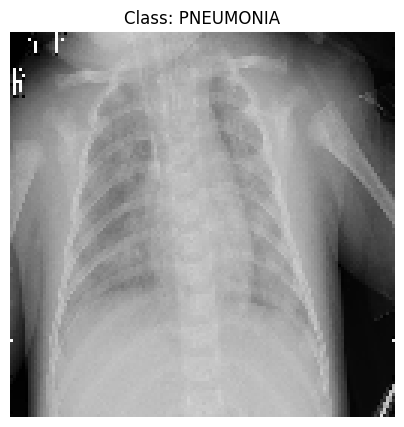

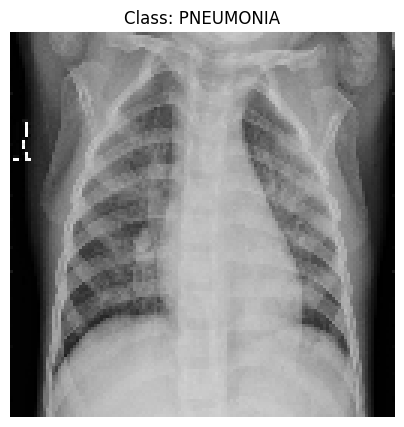

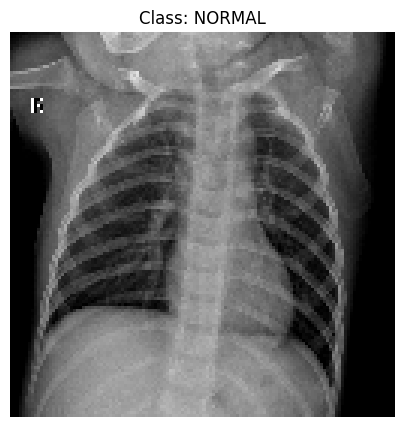

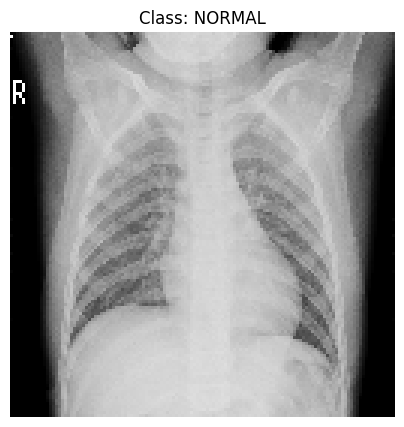

In [ ]:
# Select 5 images from validation set
images_list = []
labels_list = []
for images, labels in valid_ds:
  images_list.extend(images[:5])  # Add up to 5 images from the batch
  labels_list.extend(labels[:5])  # Add corresponding labels
  if len(images_list) >= 5:
    break

# Print 5 images
for i in range(min(5, len(images_list))):  # Iterate through available images
    plt.figure(figsize=(5, 5))
    plt.imshow(images_list[i])
    plt.title(f"Class: {class_names[labels_list[i]]}")
    plt.axis('off')
    plt.show()

**2.2 Apply GradCam to train models. For this consider:**
*  We are providing you with 2 models `07_lab_gradcam_model_resnet_10.keras` and `07_lab_gradcam_model_resnet_best.keras`. Load them into your environment.



In [ ]:
#solution
model_1_filepath = '/content/data_folder/data_folder/06_chest_xray_models/07_lab_gradcam_model_resnet_best.keras'
model_2_filepath = '/content/data_folder/data_folder/06_chest_xray_models/07_lab_gradcam_model_resnet_10.keras'

resnet_best = keras.saving.load_model(model_1_filepath, custom_objects=None, compile=True, safe_mode=True)
resnet_10 = keras.saving.load_model(model_2_filepath, custom_objects=None, compile=True, safe_mode=True)

print("resnet_best:")
resnet_best.summary()

print("resnet_10:")
resnet_10.summary()


resnet_best:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 57,668,483 (219.99 MB)

 Trainable params: 57,615,361 (219.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 2 (12.00 B)

resnet_10:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 57,668,483 (219.99 MB)

 Trainable params: 57,615,361 (219.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 2 (12.00 B)

**2.3 Obtain your gradcam visualization for `both` models:**
* Obtain the gradcam superimposed visualization for 5 images. Choose the last convolutional layer to do this.
* Also print the actual and predicted class
* Comment on the results - which one you think is making more sense?


In [ ]:
resnet_best_layer_name = "conv5_block3_out"
resnet_10_layer_name = "conv5_block3_out"

In [ ]:
resnet_best_layer = resnet_best.get_layer(resnet_best_layer_name)
resnet_10_layer = resnet_10.get_layer(resnet_10_layer_name)

In [ ]:
# Create a models that outputs both the last conv layer's activations and predictions
gradcam_model_resnet_best = tf.keras.models.Model(
    inputs=resnet_best.inputs,
    outputs=[resnet_best_layer.output, resnet_best.output]
)

gradcam_model_resnet_10 = tf.keras.models.Model(
    inputs=resnet_10.inputs,
    outputs=[resnet_10_layer.output, resnet_10.output]
)

In [ ]:
heatmaps_resnet_best, titles_restnet_best = make_gradcam_heatmap(images_list, gradcam_model_resnet_best)

heatmaps_resnet_10, titles_resnet_10 = make_gradcam_heatmap(images_list, gradcam_model_resnet_10)

<ipython-input-53-fc655ab53bf0>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


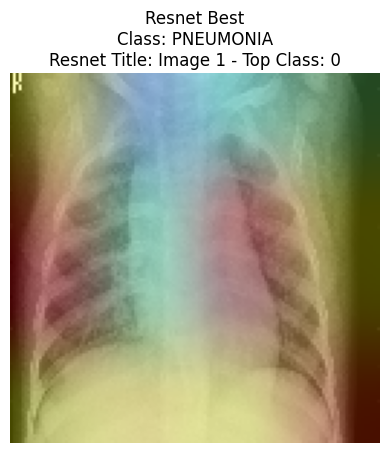

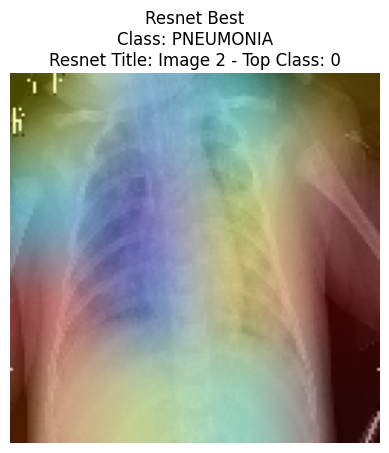

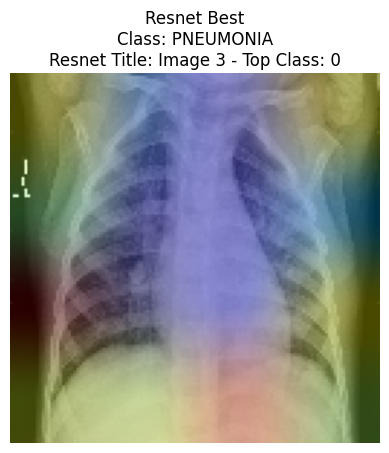

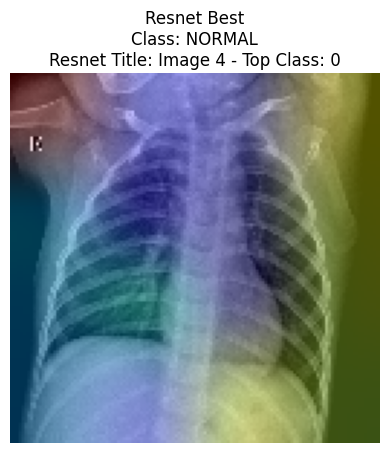

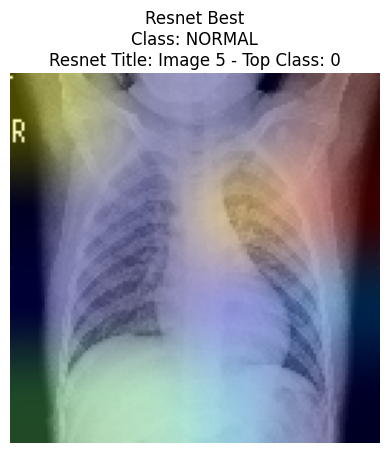

In [ ]:
for i, img in enumerate(images_list):
  img = np.expand_dims(img, axis=0)
  # Generate class activation heatmap
  img = np.squeeze(img, axis=0)
  img = np.uint8(img * 255)
  sup_img = display_gradcam(img, heatmaps_resnet_best[i])
  plt.imshow(sup_img)
  plt.title(f"Resnet Best\nClass: {class_names[labels_list[i]]}\nResnet Title: {titles_restnet_best[i]}")
  plt.axis('off')  # Remove axis ticks and labels
  plt.show()

<ipython-input-53-fc655ab53bf0>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


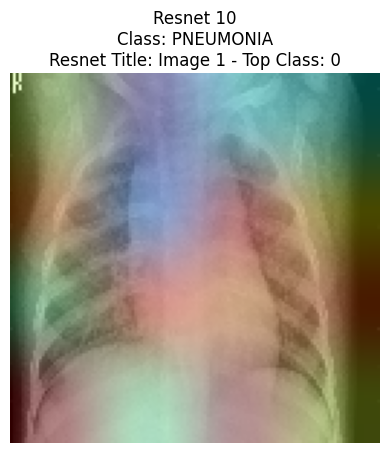

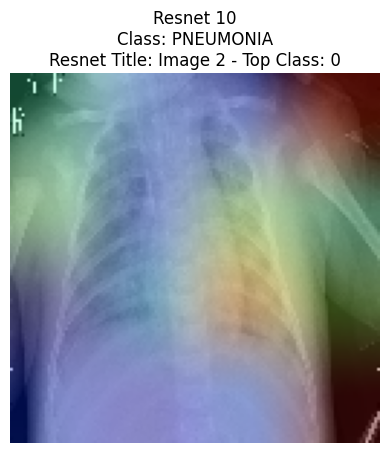

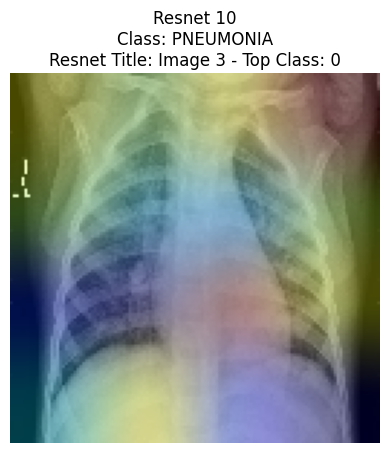

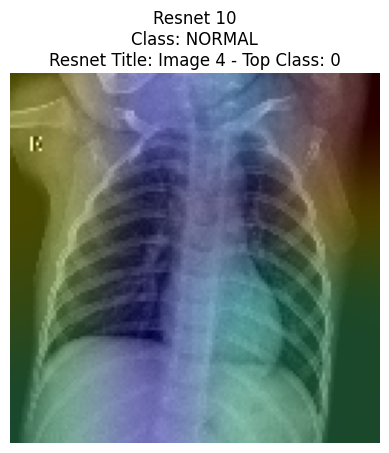

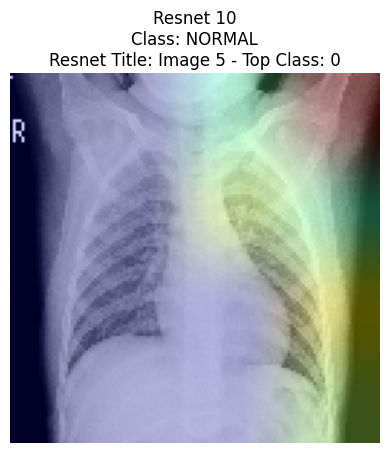

In [ ]:
for i, img in enumerate(images_list):
  img = np.expand_dims(img, axis=0)
  # Generate class activation heatmap
  img = np.squeeze(img, axis=0)
  img = np.uint8(img * 255)
  sup_img = display_gradcam(img, heatmaps_resnet_10[i])
  plt.imshow(sup_img)
  plt.title(f"Resnet 10\nClass: {class_names[labels_list[i]]}\nResnet Title: {titles_restnet_best[i]}")
  plt.axis('off')  # Remove axis ticks and labels
  plt.show()

Comment on the differences:

**SOLUTION**

The GradCAM heatmaps generated by gradcam_model_resnet_best and gradcam_model_resnet_10 show differences in localisation accuracy and focus. The heatmaps from gradcam_model_resnet_best consistently highlight the most relevant regions of the input images, concentrating activation around key features that are critical for correct classification, in the case of these images this area corresponding to the lungs. In contrast, the heatmaps from gradcam_model_resnet_10 exhibit broader and more spread out activation patterns, which may indicate less precise feature extraction or uncertainty in identifying the more important image areas.

Moreover, gradcam_model_resnet_best appears superior in maintaining clarity and specificity across all images, suggesting a more refined ability to localise details with in the images. Visually, the heatmaps produced by gradcam_model_resnet_best provide a more interpretable output for end-users and overall, the results favor gradcam_model_resnet_best as the more reliable model for generating visual explanations of image features.



---

# **End of Lab 07: Interpretation with GradCAM**